In [17]:
import torch
import torchvision
from torchvision import transforms, datasets

In [18]:
train = datasets.MNIST('', train=True, download=True, 
    transform=transforms.Compose([transforms.ToTensor()]))

test = datasets.MNIST('', train=False, download=True, 
    transform=transforms.Compose([transforms.ToTensor()]))

train_set = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
test_set = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

In [55]:
n_epochs = 3
learning_rate = 0.001
momentum = 0.5
log_interval = 10


In [38]:
examples = enumerate(test_set)
batch_idx, (example_data, example_targets) = next(examples)

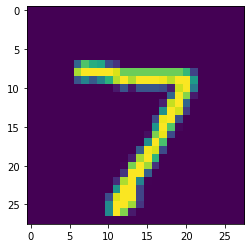

In [47]:
import matplotlib.pyplot as plt 

plt.imshow(example_data[0][0].view(28,28))
plt.show()

In [40]:
import torch.nn as nn
import torch.nn.functional as F 

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return F.log_softmax(x)    

In [42]:
import torch.optim as optim

model = Model()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [43]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(test_set.dataset) for i in range(n_epochs + 1)]

In [56]:
def train(epoch):
  model.train()
  for batch_idx, (data, y) in enumerate(train_set):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, y)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_set.dataset),
        100. * batch_idx / len(train_set), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_set.dataset)))
      

In [57]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, y in test_set:
      output = model(data)
      test_loss += F.nll_loss(output, y, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(y.data.view_as(pred)).sum()
  test_loss /= len(test_set.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_set.dataset), 100. * correct / len(test_set.dataset)))

In [58]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

: 3 [20100/60000 (34%)]	Loss: 0.003329
Train Epoch: 3 [20200/60000 (34%)]	Loss: 0.015453
Train Epoch: 3 [20300/60000 (34%)]	Loss: 0.142532
Train Epoch: 3 [20400/60000 (34%)]	Loss: 0.058589
Train Epoch: 3 [20500/60000 (34%)]	Loss: 0.030111
Train Epoch: 3 [20600/60000 (34%)]	Loss: 0.214789
Train Epoch: 3 [20700/60000 (34%)]	Loss: 0.043937
Train Epoch: 3 [20800/60000 (35%)]	Loss: 0.637070
Train Epoch: 3 [20900/60000 (35%)]	Loss: 0.020540
Train Epoch: 3 [21000/60000 (35%)]	Loss: 0.423968
Train Epoch: 3 [21100/60000 (35%)]	Loss: 0.195801
Train Epoch: 3 [21200/60000 (35%)]	Loss: 0.018053
Train Epoch: 3 [21300/60000 (36%)]	Loss: 2.446030
Train Epoch: 3 [21400/60000 (36%)]	Loss: 0.172330
Train Epoch: 3 [21500/60000 (36%)]	Loss: 0.970523
Train Epoch: 3 [21600/60000 (36%)]	Loss: 0.027476
Train Epoch: 3 [21700/60000 (36%)]	Loss: 0.161814
Train Epoch: 3 [21800/60000 (36%)]	Loss: 0.028160
Train Epoch: 3 [21900/60000 (36%)]	Loss: 0.106227
Train Epoch: 3 [22000/60000 (37%)]	Loss: 0.012572
Train Epoch

In [59]:
fig = plt.figure()
plt.plot(train_counter, train_losses)
plt.line(test_counter, test_losses)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

ValueError: x and y must be the same size